1. A first try will consist of using an LSTM architecture to see how it can predict; mainly we are intrested in predicting accuretly in a 24 hours window, but the accuracy needs to be high for short term prediction (minutes to hours)

    PEMS04 will be used, and then an LSTM will do the prediction

Unreliable permance for LSTM with high error


In [ ]:
# Cell 1: Import Libraries
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving distance.csv to distance (1).csv
Saving pems04.npz to pems04 (1).npz


Getting the data

In [ ]:
# Cell 2: Load the NPZ File and Inspect Its Contents
# Use allow_pickle=True only if necessary.
data = np.load('pems04 (1).npz', allow_pickle=True)
print("Keys in the NPZ file:", data.files)

# Access the data array (adjust the key if needed)
traffic_data = data['data']
print("Traffic data shape:", traffic_data.shape)
# Expected shape: (T, N, F) where:
# T = number of time steps, N = number of sensors, F = number of features.


Keys in the NPZ file: ['data']
Traffic data shape: (16992, 307, 3)


In [ ]:
# Cell 3: Preprocess the Data (Normalization)
# Compute the mean and standard deviation, then normalize the data.
mean = traffic_data.mean()
std = traffic_data.std()
traffic_data = (traffic_data - mean) / std


In [ ]:
class TrafficLSTMDataset(Dataset):
    def __init__(self, data, input_len=12, output_len=12):
        """
        data: numpy array of shape (T, N, F)
        input_len: number of time steps as input (history)
        output_len: number of time steps to predict (future)
        """
        self.input_len = input_len
        self.output_len = output_len

        # Create a list of samples using a sliding window over time (chronological order)
        self.samples = []
        T = data.shape[0]
        # We can only create samples if T >= input_len + output_len.
        for t in range(T - input_len - output_len + 1):
            x = data[t:t+input_len]  # shape: (input_len, N, F)
            y = data[t+input_len:t+input_len+output_len]  # shape: (output_len, N, F)
            self.samples.append((x, y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        # Convert to torch tensors
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Normalize the data: here we normalize the entire dataset (you can adjust per-feature if needed)
traffic_data_mean = traffic_data.mean()
traffic_data_std = traffic_data.std()
traffic_data = (traffic_data - traffic_data_mean) / traffic_data_std

# Create the dataset. Adjust input_len and output_len as necessary.
input_len = 12  # number of historical time steps
output_len = 12  # number of future time steps to predict
dataset = TrafficLSTMDataset(traffic_data, input_len=input_len, output_len=output_len)
print("Total number of samples:", len(dataset))


Total number of samples: 16969


In [ ]:

total_samples = len(dataset)
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size

# Create indices for chronological split.
train_indices = list(range(0, train_size))
test_indices = list(range(train_size, total_samples))

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# DataLoaders (set shuffle=False to maintain chronological order)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Total samples: {total_samples}, Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Total samples: 16969, Train samples: 13575, Test samples: 3394


In [ ]:

# %% [code]
class LSTMModel(nn.Module):
    def __init__(self, input_size=traffic_data.shape[-1], hidden_size=64, output_size=traffic_data.shape[-1], num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM will process input of shape (B*N, T_in, F)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (B, T_in, N, F)
        B, T, N, F = x.size()
        # Process each sensor’s time series separately by reshaping
        x = x.permute(0, 2, 1, 3)  # (B, N, T, F)
        x = x.reshape(B * N, T, F)

        # LSTM forward pass
        lstm_out, _ = self.lstm(x)  # lstm_out: (B*N, T, hidden_size)

        # Predict from the last time step of LSTM output
        out = self.fc(lstm_out[:, -1, :])  # shape: (B*N, output_size)

        # Reshape back to (B, N, output_size)
        out = out.reshape(B, N, -1)
        return out


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on device:", device)

model = LSTMModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

num_epochs = 3  # Increase number of epochs as needed

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for x, y in train_loader:
        x = x.to(device)  # shape (B, T_in, N, F)
        y = y.to(device)  # shape (B, T_out, N, F)

        # Forward pass: predicting only the first future time step (t+1)
        pred = model(x)  # shape: (B, N, F)
        loss = loss_fn(pred, y[:, 0, :, :])  # compare with ground truth at t+1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Training on device: cuda
Epoch 1/3, Loss: 0.1114
Epoch 2/3, Loss: 0.0223
Epoch 3/3, Loss: 0.0218


In [ ]:
model_weights_file = "lstm_model_weights.pth"
torch.save(model.state_dict(), model_weights_file)
print(f"Model weights saved to {model_weights_file}")


Model weights saved to lstm_model_weights.pth


In [ ]:
model.load_state_dict(torch.load(model_weights_file, map_location=device))
model.eval()

predictions_list = []
ground_truth_list = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        # Model outputs one-step forecast: shape (B, N, F)
        pred = model(x)
        predictions_list.append(pred.cpu())
        # Ground truth for the first time step of the output sequence
        ground_truth_list.append(y[:, 0, :, :].cpu())

# Concatenate results
predictions = torch.cat(predictions_list, dim=0)  # Shape: (Total_test_samples, N, F)
ground_truth = torch.cat(ground_truth_list, dim=0)  # Shape: (Total_test_samples, N, F)

print("Predictions shape:", predictions.shape)
print("Ground truth shape:", ground_truth.shape)


Predictions shape: torch.Size([3394, 307, 3])
Ground truth shape: torch.Size([3394, 307, 3])


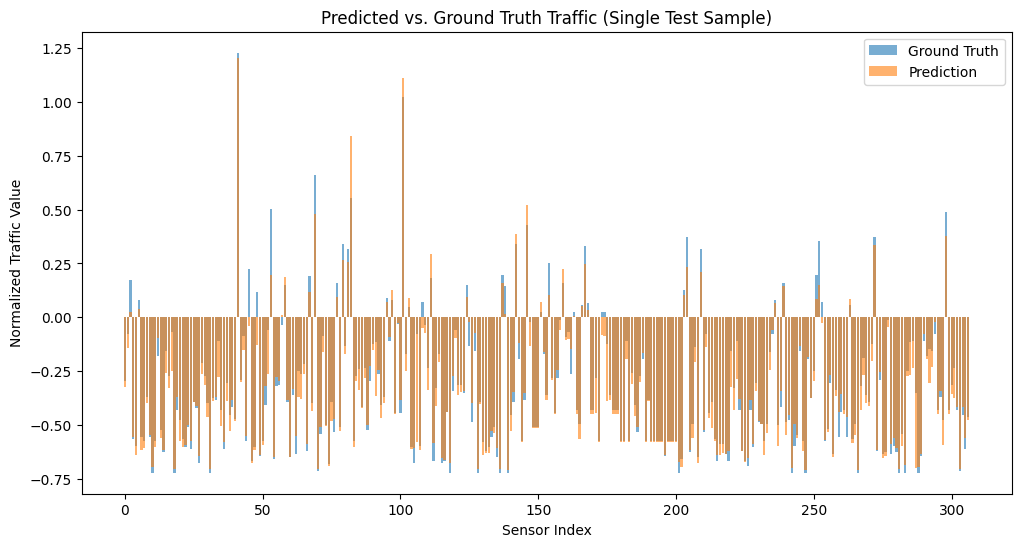

In [ ]:
# Option A: Bar Chart for a Single Sample across Sensors.
sample_idx = 0
# Retrieve predictions and ground truth for the chosen sample.
# Expected shape: (N, F) -- if F > 1, we select the first feature.
pred_sample = predictions[sample_idx].squeeze()  # shape: (N, F)
true_sample = ground_truth[sample_idx].squeeze()   # shape: (N, F)

# If there is more than one feature, select the first one for plotting.
if len(pred_sample.shape) == 2 and pred_sample.shape[1] > 1:
    pred_sample = pred_sample[:, 0]
    true_sample = true_sample[:, 0]

plt.figure(figsize=(12, 6))
sensor_ids = range(len(pred_sample))
plt.bar(sensor_ids, true_sample, alpha=0.6, label="Ground Truth", color='tab:blue')
plt.bar(sensor_ids, pred_sample, alpha=0.6, label="Prediction", color='tab:orange')
plt.xlabel("Sensor Index")
plt.ylabel("Normalized Traffic Value")
plt.title("Predicted vs. Ground Truth Traffic (Single Test Sample)")
plt.legend()
plt.show()

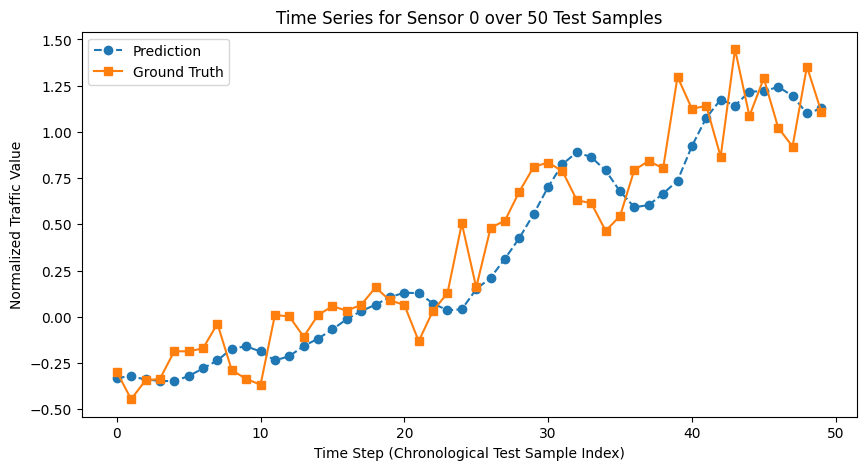

In [ ]:
sensor_index = 0
num_samples_to_plot = 50  # number of consecutive test samples

# Extract predictions and ground truth for sensor 0 (and assuming F=1, taking the first feature)
pred_series = predictions[:num_samples_to_plot, sensor_index, 0].numpy()
true_series = ground_truth[:num_samples_to_plot, sensor_index, 0].numpy()

plt.figure(figsize=(10, 5))
plt.plot(range(num_samples_to_plot), pred_series, marker='o', linestyle='--', label="Prediction")
plt.plot(range(num_samples_to_plot), true_series, marker='s', label="Ground Truth")
plt.xlabel("Time Step (Chronological Test Sample Index)")
plt.ylabel("Normalized Traffic Value")
plt.title(f"Time Series for Sensor {sensor_index} over {num_samples_to_plot} Test Samples")
plt.legend()
plt.show()

Iterative prediction

In [ ]:
import torch
import matplotlib.pyplot as plt

model.eval()

# Number of future steps to predict (should match output_len used in dataset)
num_forecast_steps = output_len
all_iterative_predictions = []
all_ground_truth = []

with torch.no_grad():
    for x, y in test_loader:
        # x: shape (B, T_in, N, F), and y: shape (B, T_out, N, F)
        B, T_in, N, F = x.shape

        # We'll collect our iterative predictions here; one prediction per forecast step.
        iterative_preds = []

        # Clone the initial input sequence (true history) to avoid modifying the original x.
        input_seq = x.to(device).clone()

        for step in range(num_forecast_steps):
            # Predict one step ahead using the current input_seq.
            # The model returns a prediction for the next time step: shape (B, N, F)
            pred = model(input_seq)

            # Append the prediction to our list.
            iterative_preds.append(pred.cpu())

            # Prepare the input for the next forecast step:
            # Remove the first time step and append the new prediction.
            # Note: unsqueeze to add a time dimension so that pred has shape (B, 1, N, F).
            input_seq = torch.cat((input_seq[:, 1:, :, :], pred.unsqueeze(1)), dim=1)

        # Stack all predictions along the time axis.
        # iterative_preds becomes a tensor with shape: (B, num_forecast_steps, N, F)
        iterative_preds = torch.stack(iterative_preds, dim=1)

        all_iterative_predictions.append(iterative_preds)
        all_ground_truth.append(y.cpu())

# Concatenate results from all batches.
iterative_predictions = torch.cat(all_iterative_predictions, dim=0)  # (Total_samples, T_out, N, F)
ground_truth_all = torch.cat(all_ground_truth, dim=0)               # (Total_samples, T_out, N, F)

print("Iterative predictions shape:", iterative_predictions.shape)
print("Ground truth shape:", ground_truth_all.shape)


Iterative predictions shape: torch.Size([3394, 12, 307, 3])
Ground truth shape: torch.Size([3394, 12, 307, 3])


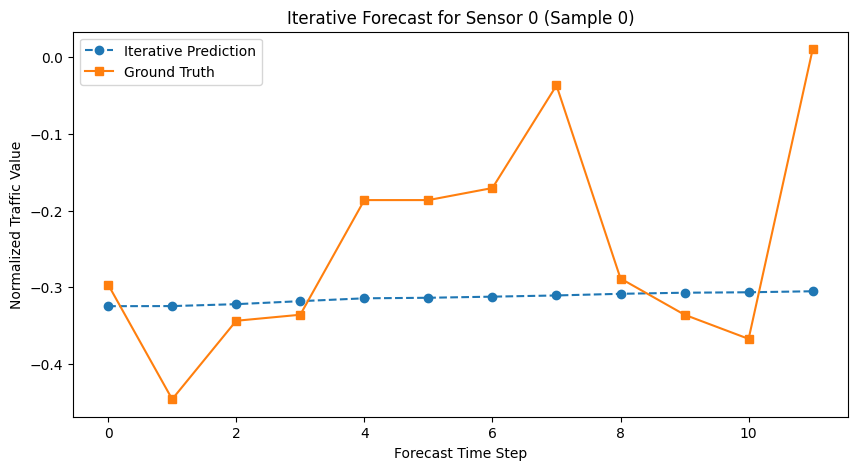

In [ ]:
# Choose sample index 0 from the test set for plotting
sample_idx = 0
sensor_index = 0  # change as needed
# We assume only one feature (F = 1). If more, select the first feature.
pred_series = iterative_predictions[sample_idx, :, sensor_index, 0].numpy()
true_series = ground_truth_all[sample_idx, :, sensor_index, 0].numpy()

plt.figure(figsize=(10, 5))
plt.plot(range(num_forecast_steps), pred_series, marker='o', linestyle='--', label="Iterative Prediction")
plt.plot(range(num_forecast_steps), true_series, marker='s', label="Ground Truth")
plt.xlabel("Forecast Time Step")
plt.ylabel("Normalized Traffic Value")
plt.title(f"Iterative Forecast for Sensor {sensor_index} (Sample {sample_idx})")
plt.legend()
plt.show()
